In [1]:
# join Normal density and regression
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal as mvnorm
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as LR
# %matplotlib inline

In [2]:
def conditional_pdf(x, mux, muy, sigma):
    """pdf(y|x) ~ N(mean, var)"""
    mean = muy + sigma[1,0] /sigma[0,0] * (x - mux)
    var = sigma[1,1] - sigma[1,0] /sigma[0,0] * sigma[0,1]
    return mean, var

def conditional_mean(u, mux, muy, sigma, option = 'y|x'):
    """ E(y|x) or E(x|y: regression in bivariate normal"""
    sig_xx = sigma[0,0]
    sig_yy = sigma[1,1]
    sig_xy = sigma[0,1]
    sig_yx = sigma[1,0]
    if option == 'x|y':
        fit = mux + sig_xy / sig_yy * (u - muy)
    else:
        fit = muy + sig_yx / sig_xx * (u - mux)

    return fit

In [3]:
sigma = np.array([2,1,1,3]).reshape(2,2)
mux, muy = 0,0
mu = np.array([mux, muy])
rv = mvnorm(mu, sigma)

In [4]:
x, y = np.mgrid[-6:6:.01, -6:6:.01]
pos = np.empty(x.shape + (2,)) 
pos[:,:,0] = x
pos[:,:,1] = y

In [5]:
# principal component is the largest eigen vector
# eigenvalue decomposition:  sigma = v @ np.diag(w) @ v.T 
# note:  A @ B is matrix product
w, v = np.linalg.eig(sigma)

print(w)
print(v)
(v @ np.diag(w) @ v.T) / sigma  # check

[1.38196601 3.61803399]
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


array([[1., 1.],
       [1., 1.]])

In [6]:
# eigen vectors
v0 = v[:,0]
v1 = v[:,1]
(v0 @ sigma) / (w[0] * v0)
(v1 @ sigma) / (w[1] * v1) 
np.all((v0 @ v1) == 0)  # v0, v1 are orthogonal

True

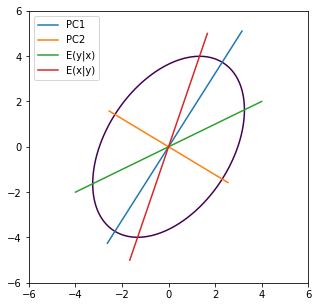

In [7]:
# plot x,y in same scale to demonstrate the othrogonality of the two principal components
plt.figure(figsize=(5,5))  
plt.contour(x,y, rv.pdf(pos), [.005])

# regression line y|x = m(x)
gridx = np.arange(-4,5)
fity = [conditional_mean(u, mux, muy, sigma, 'y|x') for u in gridx]

# regression line x/y = m(y)
gridy = np.arange(-5,6)
fitx = [conditional_mean(u, mux, muy, sigma, 'x|y') for u in gridy]

# principal component 1,2 (order by eigen value)
xy1 = np.array([v1 * u + [mux, muy] for u in np.arange(-6,6)])
xy0 = np.array([v0 * u + [mux, muy] for u in np.arange(-3,4)])


plt.plot(xy1[:,0], xy1[:,1])
plt.plot(xy0[:,0], xy0[:,1])
plt.plot(gridx, fity)
plt.plot(fitx, gridy)
plt.legend(['PC1', 'PC2', 'E(y|x)', 'E(x|y)'])

plt.show()

In [8]:
def empirical_regression(x, y):
    """
    empirical regression y|x = m(x) derived from join pdf p(x,y)     
    """
    mux = np.mean(x)
    muy = np.mean(y)
    var_matrix = np.cov(x, y)
    sig_yx = var_matrix[1,0]
    sig_xx = var_matrix[0,0]
    
    slope = sig_yx / sig_xx
    intercept = muy - slope * mux
    model = lambda u: muy + slope * (u - mux)
    return slope, intercept, model

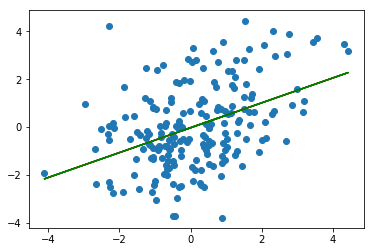

In [9]:
rv = mvnorm(mu, sigma)
sim_data = rv.rvs(200)

x = sim_data[:,0]
y = sim_data[:,1]

slope, intercept, mod1 = empirical_regression(x, y)

yfit = [mod1(u) for u in x]

plt.scatter(x,y)
plt.plot(x, yfit, 'r')

mod2 = LR()
mod2.fit(x[:,np.newaxis], y)
yfit2 = mod2.predict(x[:,np.newaxis])
plt.plot(x, yfit2,'g')

In [10]:
# compare empirical_regression() vs sklearn.linear_model
coef, intercept, model_emp = empirical_regression(x,y)
#
model_ls = LR()
model_ls.fit(x[:, np.newaxis], y)
[model_ls.intercept_, intercept, model_ls.coef_[0], coef]

[-0.027301382254125445,
 -0.027301382254125487,
 0.5211926072364982,
 0.5211926072364986]

In [11]:
stats.linregress(sim_data)

LinregressResult(slope=0.5211926072364986, intercept=-0.027301382254125487, rvalue=0.42532311366857717, pvalue=3.430633340400861e-10, stderr=0.07881614627921672)

In [12]:
# lsfit y = a + bx and E(y|x) from pdf should agree.
[slope, conditional_mean(1, 0, 0, np.cov(sim_data.T))]

[0.5211926072364986, 0.5211926072364986]